In [204]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import operator
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix

In [205]:
# Reading through the IMDB data to see what peoples feelings were towards movies
data = pd.read_csv('imdb_labelled.txt', delimiter = '\t', header = None)
data.columns = ['message', 'rating']

In [206]:
data.head() # I have to recode the above lines after every holdout since it doesn't seem to
#keep the 'data' variable clean after coding one. We should talk about why.

,message,rating
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [207]:
# building separate dataframes from the positive and negative reviews
pos_data = data[data['rating'] == 1]['message'].reset_index(drop = True)
neg_data = data[data['rating'] == 0]['message'].reset_index(drop = True)

In [208]:
#building dictionaries to find the most common words for each review type
pos_dict = {}
neg_dict = {}
for i in pos_data:
    sen = str(i).lower().split(' ')
    for word in sen:
        if word not in pos_dict:
            pos_dict[word] = 1
        else:
            pos_dict[word] += 1            

for i in neg_data:
    sen = str(i).lower().split(' ')
    for word in sen:
        if word not in neg_dict:
            neg_dict[word] = 1
        else:
            neg_dict[word] += 1
            

In [209]:
sorted_pos_dict = sorted(pos_dict.items(), key=operator.itemgetter(1), reverse = True)
sorted_neg_dict = sorted(neg_dict.items(), key=operator.itemgetter(1), reverse = True)

In [210]:
df_pos = pd.DataFrame(sorted_pos_dict)
df_pos.columns = ['word', 'count']
df_neg = pd.DataFrame(sorted_neg_dict)
df_neg.columns = ['word', 'count']

In [211]:
#merging positive and negative lists to get counts for each
posneg_df = pd.merge(df_pos, df_neg, on='word', how='outer')
posneg_df.columns = ['word', 'positive', 'negative']

#building a dataframe that calculates absolute difference in word appearance counts
posneg_df['straight difference'] = abs(posneg_df.positive - posneg_df.negative)

#dataframe that calculates ratio difference
posneg_df['ratio difference'] = abs((posneg_df.negative / (posneg_df.positive + posneg_df.negative)))

In [212]:
posneg_df.head()

,word,positive,negative,straight difference,ratio difference
0,,842.0,910.0,68.0,0.519406
1,the,388.0,407.0,19.0,0.511950
2,and,249.0,170.0,79.0,0.405728
3,a,227.0,200.0,27.0,0.468384
4,of,184.0,189.0,5.0,0.506702


In [213]:
# I used a lot of the words high on this list figuring the larger the difference in usage
# the more effect it would have on the predictive value of the model
posneg_df.sort_values(by = 'negative', ascending = False)[101:140]

,word,positive,negative,straight difference,ratio difference
158,scenes,6.0,9.0,3.0,0.600000
113,films,8.0,9.0,1.0,0.529412
51,when,16.0,9.0,7.0,0.360000
68,movies,12.0,9.0,3.0,0.428571
58,its,14.0,9.0,5.0,0.391304
167,get,5.0,9.0,4.0,0.642857
159,never,6.0,9.0,3.0,0.600000
105,way,8.0,8.0,0.0,0.500000
98,into,9.0,8.0,1.0,0.470588
217,script,4.0,8.0,4.0,0.666667


In [214]:
data.head()

,message,rating
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [215]:
# Building my keyword list
data1 = data

keywords_mine = ['and',
            'even',
            'good',
            'plot',
            'enjoy',
            'best', #not very strong
            'love',
            'cool', #also pretty weak
            'awesome',
            'film',
            'for',
            'is',
            'was',
            'i',
            'not',
            'a',
            'to',
            'just',
            'know',
            'wonderful',
            'only',
            'great',
            'bad.',
            'waste',
            'like',
            'really',
            'excellent',
           ]
for key in keywords_mine:
    data1[str(key)] = data1.message.str.contains(
        str(key), case = False #getting rid of the spaces in order to find words at beginning or end of sentences
    )
    
# Pretty light correlation outside of 'was' and 'waste' from from the sentence 'this 
# movie was a waste of time'

trainer1 = data1[keywords_mine]
target1 = data1['rating']

#creating an instantiating variable for the BernoulliNB
bnb1 = BernoulliNB()

bnb1.fit(trainer1, target1)

y_pred1 = bnb1.predict(trainer1)

print("Number of incorrectly predicted ratings out of a total {} reviews : {}".format(
    trainer1.shape[0],
    (target1 != y_pred1).sum()
))

print(confusion_matrix(target1, y_pred1))

Number of incorrectly predicted ratings out of a total 748 reviews : 208
[[258 104]
 [104 282]]


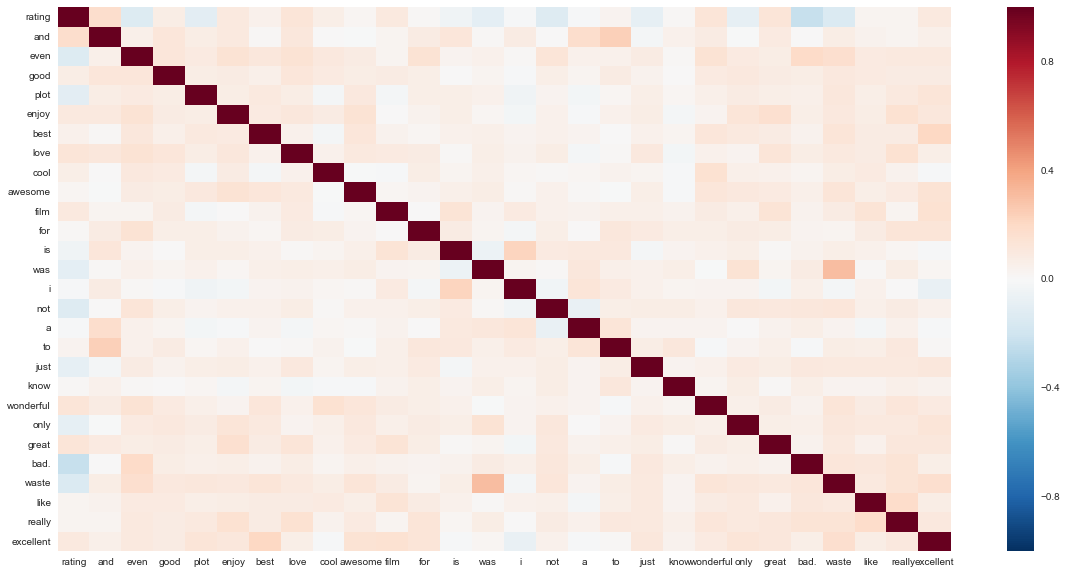

In [216]:
plt.figure(figsize = (20,10))
sns.heatmap(data1.corr())

In [217]:
data = pd.read_csv('imdb_labelled.txt', delimiter = '\t', header = None)
data.columns = ['message', 'rating']
data.head()

,message,rating
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [218]:
# Building a keyword list based on the straight difference count
data2 = data

keywords_straight_diff = ['and',
    'is',
    'was',
    'bad',
    'a',
    'to',
    'just',
    'even',
    'i',
    'the',
    'no',
    'that',
    'how',
    'in',
    'for',
    "didn't",
    'good',
    'plot',
    'would',
    'wonderful',
    'only',
    'there',
    '\t\ni',
    'it',
    'great'
]
                          
for key in keywords_straight_diff:
    data2[str(key)] = data2.message.str.contains(
        str(key), case = False #getting rid of the spaces in order to find words at beginning or end of sentences
    )

trainer2 = data2[keywords_straight_diff]
target2 = data2['rating']

#creating an instantiating variable for the BernoulliNB
bnb2 = BernoulliNB()

bnb2.fit(trainer2, target2)

y_pred2 = bnb2.predict(trainer2)

print("Number of incorrectly predicted ratings out of a total {} reviews : {}".format(
    trainer2.shape[0],
    (target2 != y_pred2).sum()
))

print(confusion_matrix(target2, y_pred2))

Number of incorrectly predicted ratings out of a total 748 reviews : 226
[[208 154]
 [ 72 314]]


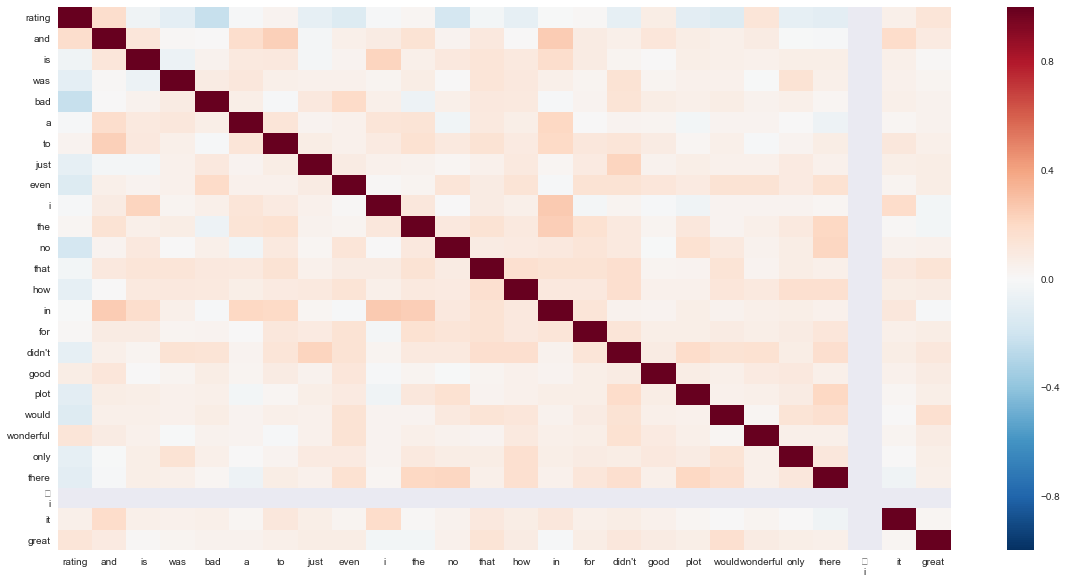

In [219]:
plt.figure(figsize = (20,10))
sns.heatmap(data2.corr())

In [220]:
data = pd.read_csv('imdb_labelled.txt', delimiter = '\t', header = None)
data.columns = ['message', 'rating']
data.head()

,message,rating
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [221]:
# Building a keyword list based on the ratio difference count
data3 = data

keywords_ratio_diff = ['waste',
                      'show',
                      'nothing',
                      'am',
                      'line',
                      'bad',
                      '\t\ni',
                      'seen.',
                      "didn't",
                      'plot',
                      'work',
                      'especially',
                      'half',
                      'terrible,',
                      "i'm",
                      'lacks',
                      'films',
                      'would',
                      'even',
                      'beyond',
                      'predictable',
                      'why',
                      'funny.',
                      'well,'
]
                          
for key in keywords_ratio_diff:
    data3[str(key)] = data3.message.str.contains(
        str(key), case = False #getting rid of the spaces in order to find words at beginning or end of sentences
    )

trainer3 = data3[keywords_ratio_diff]
target3 = data3['rating']

#creating an instantiating variable for the BernoulliNB
bnb3 = BernoulliNB()

bnb3.fit(trainer3, target3)

y_pred3 = bnb3.predict(trainer3)

print("Number of incorrectly predicted ratings out of a total {} reviews : {}".format(
    trainer3.shape[0],
    (target3 != y_pred3).sum()
))

print(confusion_matrix(target3, y_pred3))

Number of incorrectly predicted ratings out of a total 748 reviews : 249
[[154 208]
 [ 41 345]]


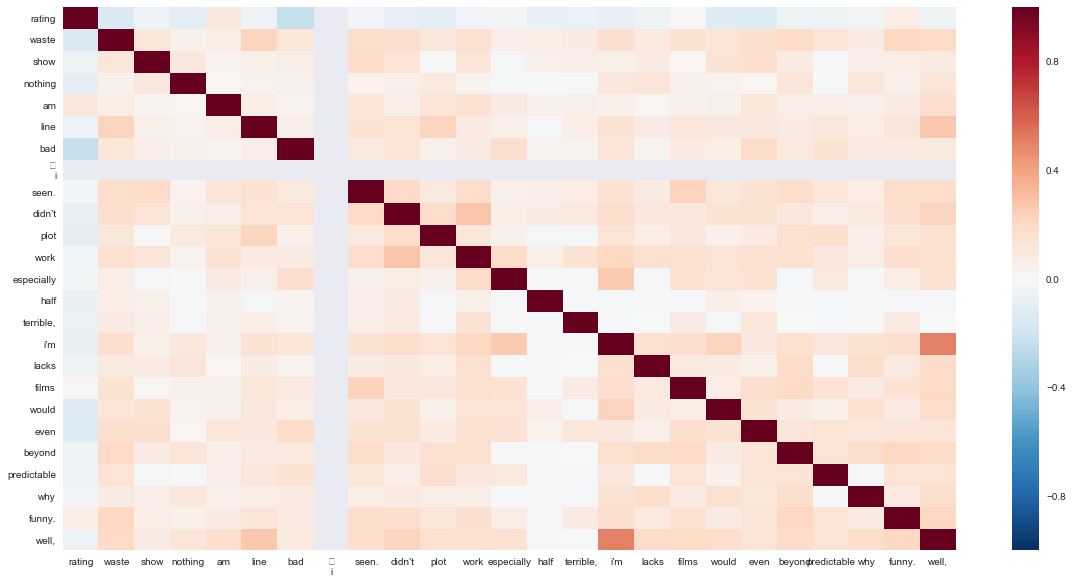

In [222]:
plt.figure(figsize = (20,10))
sns.heatmap(data3.corr())

In [223]:
data = pd.read_csv('imdb_labelled.txt', delimiter = '\t', header = None)
data.columns = ['message', 'rating']
data.head()

,message,rating
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [224]:
# Building a keyword list based on the most common positive words that are not base words
# base words being your (a, the, if, or, and type words)
data4 = data

keywords_pos_words = [
    'movie',
    'film',
    'good',
    'great',
    'like',
    'more',
    'wonderful',
    'best',
    'love',
    'character',
    'worth',
    'excellent',
    'recommend',
    'interesting',
    'enjoyed',
    'well.',
    '10',
    'it!',
    'special',
    'perfect'
]
                          
for key in keywords_pos_words:
    data4[str(key)] = data4.message.str.contains(
        str(key), case = False #getting rid of the spaces in order to find words at beginning or end of sentences
    )

trainer4 = data4[keywords_pos_words]
target4 = data4['rating']

#creating an instantiating variable for the BernoulliNB
bnb4 = BernoulliNB()

bnb4.fit(trainer4, target4)

y_pred4 = bnb4.predict(trainer4)

print("Number of incorrectly predicted ratings out of a total {} reviews : {}".format(
    trainer4.shape[0],
    (target4 != y_pred4).sum()
))

print(confusion_matrix(target4, y_pred4))

Number of incorrectly predicted ratings out of a total 748 reviews : 256
[[259 103]
 [153 233]]


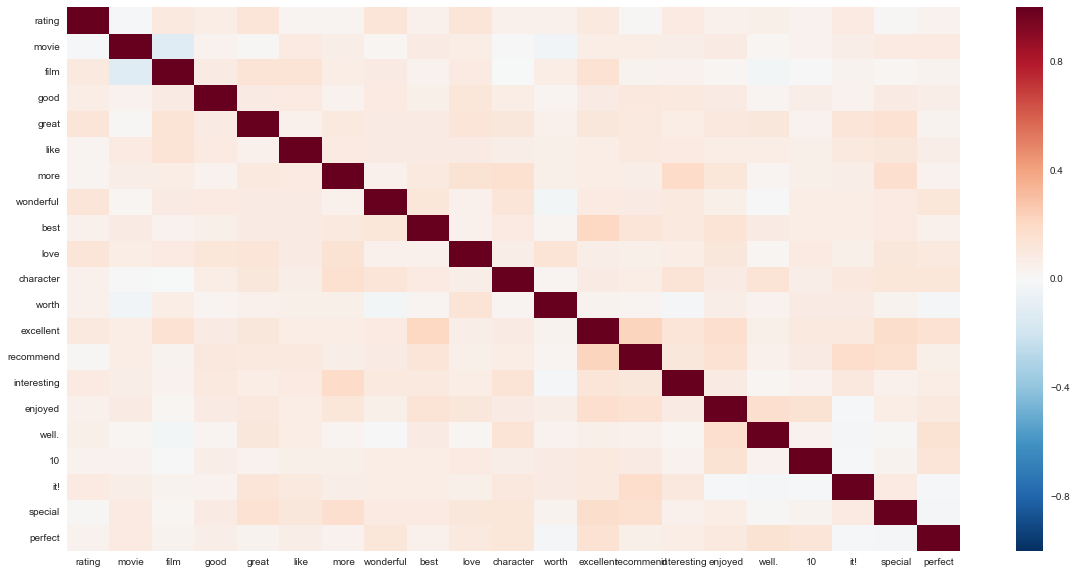

In [225]:
plt.figure(figsize = (20,10))
sns.heatmap(data4.corr())

In [226]:
data = pd.read_csv('imdb_labelled.txt', delimiter = '\t', header = None)
data.columns = ['message', 'rating']
data.head()

,message,rating
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [227]:
# Building a keyword list based on the most common negative words that are not base words
# base words being your (a, the, if, or, and type words)
data5 = data

keywords_neg_words = [
    'movie',
    'just',
    'bad',
    'even',
    'no',
    'only',
    'plot',
    "didn't",
    'how',
    'your',
    'waste',
    'little',
    'nothing',
    'worst',
    'stupid',
    'worse',
    'awful'
]
                          
for key in keywords_neg_words:
    data5[str(key)] = data5.message.str.contains(
        str(key), case = False #getting rid of the spaces in order to find words at beginning or end of sentences
    )

trainer5 = data5[keywords_neg_words]
target5 = data5['rating']

#creating an instantiating variable for the BernoulliNB
bnb5 = BernoulliNB()

bnb5.fit(trainer5, target5)

y_pred5 = bnb5.predict(trainer5)

print("Number of incorrectly predicted ratings out of a total {} reviews : {}".format(
    trainer5.shape[0],
    (target5 != y_pred5).sum()
))

print(confusion_matrix(target5, y_pred5))

Number of incorrectly predicted ratings out of a total 748 reviews : 229
[[205 157]
 [ 72 314]]


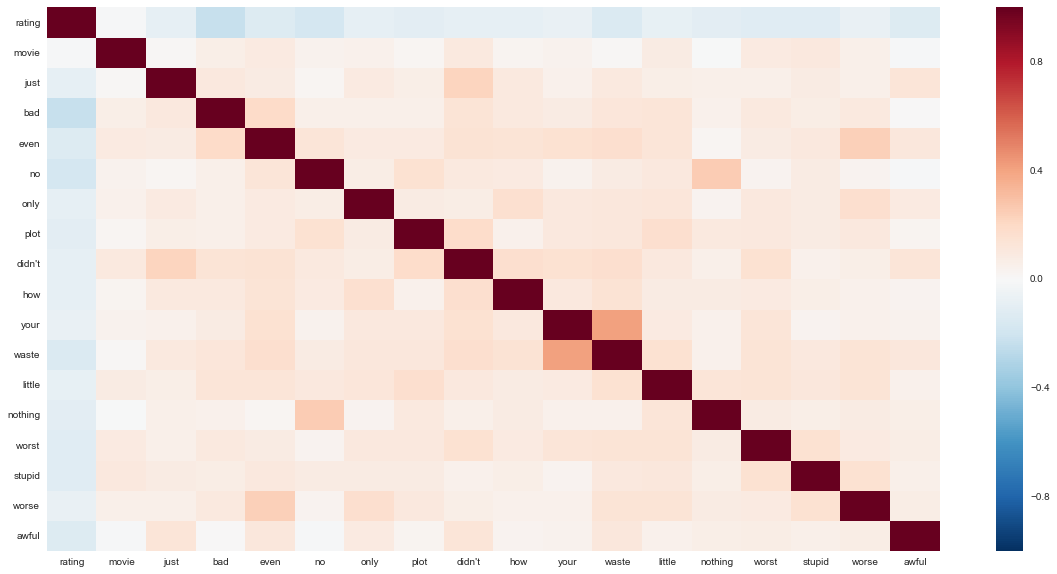

In [228]:
plt.figure(figsize = (20,10))
sns.heatmap(data5.corr())

In [229]:
# Looking at all of the confusion matrixes
print('Confusion Matrix 1 - My Keywords')
print(confusion_matrix(target1, y_pred1))
print('-'*40)
print('Confusion Matrix 2 - Keywords with highest straight differential')
print(confusion_matrix(target2, y_pred2))
print('-'*40)
print('Confusion Matrix 3 - Keywords with highest ratio differential')
print(confusion_matrix(target3, y_pred3))
print('-'*40)
print('Confusion Matrix 4 - Most common positive Keywords')
print(confusion_matrix(target4, y_pred4))
print('-'*40)
print('Confusion Matrix 5 - Most common negative Keywords')
print(confusion_matrix(target5, y_pred5))

Confusion Matrix 1 - My Keywords
[[258 104]
 [104 282]]
----------------------------------------
Confusion Matrix 2 - Keywords with highest straight differential
[[208 154]
 [ 72 314]]
----------------------------------------
Confusion Matrix 3 - Keywords with highest ratio differential
[[154 208]
 [ 41 345]]
----------------------------------------
Confusion Matrix 4 - Most common positive Keywords
[[259 103]
 [153 233]]
----------------------------------------
Confusion Matrix 5 - Most common negative Keywords
[[205 157]
 [ 72 314]]


## Do any of your classifiers seem to overfit?

None of my classifiers seem to overfit.

## Which seem to perform the best and why?

I think based on straight numbers, my Keywords had the best predictive value. That being said the purely negative words model was strongly able to identify negative reviews, no surpise there. What was a surprise though was that the ratio model was the best at correctly predicting negative reviews. The pure positive words model was barely better than my own keywords at correctly predicting positive reviews and suffers strongly in correctly predicting negative reviews.

## What features seem to be most impactful to performance

Derek you were right, the ratio was a good way to go. It is definitely strong in correctly predicting negative reviews, a deeper dive into the word mix for that model vs mine might be able to identify some commonalities and where these two can be combined to increase the positive predictive power without suffering too much loss of predictive ability on the negative side.